### **Text Mining Group Project 23-24**

##### **Group 3**

**Elements**:
- Afonso Gorjão | 20230575 | 20230575@novaims.unl.pt
- Diogo Almeida | ... | ...@novaims.unl.pt
- Frederico Portela | R20181072 | r20181072@novaims.unl.pt
- Pedro Carvalho | 20230554 | 20230554@novaims.unl.pt


**In this notebook:**
1. Data Extraction from raw file.

**Index**
1. [Library imports](#library_imports)
2. ...

#### **Library Imports**<a id='library_imports'></a>

In [16]:
import os
import re
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer

from bs4 import BeautifulSoup

import fasttext

from sklearn.model_selection import train_test_split

#### **Constants**

In [2]:
SEED = 42

CORPORA_PATH = os.path.join('corpora', 'raw-data')

TRAIN_INFO_PATH = os.path.join(CORPORA_PATH, 'train.xlsx')
TRAIN_REVIEWS_PATH = os.path.join(CORPORA_PATH, 'train_reviews.xlsx')

TEST_INFO_PATH = os.path.join(CORPORA_PATH, 'test.xlsx')
TEST_REVIEWS_PATH = os.path.join(CORPORA_PATH, 'test_reviews.xlsx')

#### **Data Imports**

In [3]:
class Metadata:
    
    """
    Easy access to metadata for the Airbnb dataset.
    """
    
    descriptions = {
        'index': 'index column to identify each property',
        'description': 'property description',
        'host_about': 'host information',
        'unlisted': 'target column: whether the property is unlisted (1) or not (0)',
        'comments': 'guest comments on the property. A property can have multiple or no comments',
    }
    
    @classmethod
    def describe(cls, column):
        return cls.descriptions[column]


# example
print(Metadata.describe('index'))

index column to identify each property


In [3]:
train_info = pd.read_excel(TRAIN_INFO_PATH)
train_reviews = pd.read_excel(TRAIN_REVIEWS_PATH)

print(f'Train info shape: {train_info.shape}')
display(train_info.head())
print()
print(f'Train reviews shape: {train_reviews.shape}')
display(train_reviews.head())

# time to load: ~25s

Train info shape: (6248, 4)


,index,description,host_about,unlisted
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0
4,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0



Train reviews shape: (361281, 2)


,index,comments
0,1,this is a very cozy and comfortable house to s...
1,1,good<br/>
2,1,"My first hostel experience, and all I have to ..."
3,1,Das Hostel war neu und deshalb funktionierte a...
4,1,"It was fine for a dorm, but I think for the pe..."


In [4]:
# we might also want to check the test data to ensure compatibility
test_info = pd.read_excel(TEST_INFO_PATH)
test_reviews = pd.read_excel(TEST_REVIEWS_PATH)

assert test_info.columns.tolist() == train_info.columns.tolist()[:-1], 'Test and train info columns do not match'
assert test_reviews.columns.tolist() == train_reviews.columns.tolist(), 'Test and train reviews columns do not match'

#### **Data Exploration**

- **High-level Statistics**

In [5]:
# missing values

# there seems to be blank spaces not being identified as nulls
# r'^\s*$' matches strings that are empty or contain only whitespace
# ^ asserts the start of the string
# \s* matches zero or more whitespace characters (spaces, tabs, newlines, etc.)
# $ asserts the end of the string
train_info = train_info.replace(r'^\s*$', np.nan, regex=True)
train_reviews = train_reviews.replace(r'^\s*$', np.nan, regex=True)

print('Train info missing values:')
print(train_info.isna().sum())

print('\nTrain reviews missing values:')
print(train_reviews.isna().sum())

# to the same to the test set
test_info = test_info.replace(r'^\s*$', np.nan, regex=True)
test_reviews = test_reviews.replace(r'^\s*$', np.nan, regex=True)

print('\nTest info missing values:')
print(test_info.isna().sum())

print('\nTest reviews missing values:')
print(test_reviews.isna().sum())

Train info missing values:
index           0
description     0
host_about     24
unlisted        0
dtype: int64

Train reviews missing values:
index       0
comments    2
dtype: int64

Test info missing values:
index          0
description    0
host_about     2
dtype: int64

Test reviews missing values:
index       0
comments    0
dtype: int64


In [21]:
# is index unique in train_info?
assert train_info['index'].nunique() == train_info.shape[0], 'Index is not unique'
print(f'Total no. of properties in train dataset: {train_info.shape[0]}')

Total no. of properties in train dataset: 6248


Unlisted: 1708 (27.34%)
Listed: 4540 (72.66%)


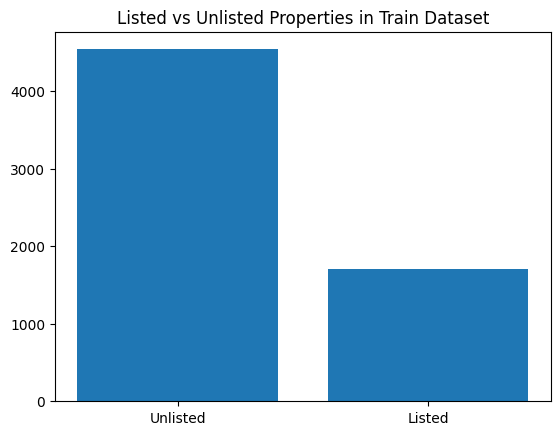

In [20]:
# listed vs unlisted
unlisted = train_info['unlisted'].value_counts()
print(f'Unlisted: {unlisted[1]} ({unlisted[1] / train_info.shape[0] * 100:.2f}%)')
print(f'Listed: {unlisted[0]} ({unlisted[0] / train_info.shape[0] * 100:.2f}%)')

plt.bar(['Unlisted', 'Listed'], unlisted)
plt.title('Listed vs Unlisted Properties in Train Dataset')
plt.show()

# ... some data imbalance, might need to address this later

In [26]:
# property reviews
reviews_per_property = train_reviews['index'].value_counts()

total_properties = train_info.shape[0]
properties_with_reviews = reviews_per_property.shape[0]
properties_without_reviews = total_properties - properties_with_reviews

print(f'Properties with reviews: {properties_with_reviews} ({properties_with_reviews / total_properties * 100:.2f}%)')
print(f'Properties without reviews: {properties_without_reviews} ({properties_without_reviews / total_properties * 100:.2f}%)')

Properties with reviews: 4245 (67.94%)
Properties without reviews: 2003 (32.06%)


In [33]:
# stats on reviews per property
avg_reviews_per_property = reviews_per_property.mean()
print(f'Average reviews per property: {avg_reviews_per_property:.2f}')
print(f'Median reviews per property: {reviews_per_property.median():.0f}')
print(f'Mode of reviews per property: {reviews_per_property.mode()[0]}')
print(f'Standard deviation of reviews per property: {reviews_per_property.std():.2f}')

Average reviews per property: 85.11
Median reviews per property: 48
Mode reviews per property: 1
Standard deviation of reviews per property: 96.49


- **Data Cleaning ahead of text field analysis**

In [ ]:
# language detection
# wordcounts by field (some cleaning beforehand is needed)
# sentiment analysis on comments (chi-square test to check if sentiment is correlated to target)

In [6]:
# cleaning functions
# NOTE some of this functions will be used for data pre processing!

def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    cleaned_text = soup.get_text(separator=" ")
    return cleaned_text


def remove_emojis_and_special_characters(text):
    # Regex to remove emojis and non-ASCII characters
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric shapes extended
                               u"\U0001F800-\U0001F8FF"  # Supplemental arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental symbols and pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    text = re.sub(r"[^\w\s]", '', text)  # Remove punctuation
    return text


def remove_control_characters(text):
    # Remove common problematic sequences
    text = text.replace('_x000D_', '')  # Explicitly replace carriage returns (often used to indicate line breaks)
    # Remove non-printable characters
    text = re.sub(r'[\x00-\x1f\x7f-\x9f]', '', text)
    return text


def remove_functional_punctuation(text):
    # Remove punctuation that is not indicative of sentiment
    # Keep ! and ? as they can indicate sentiment
    text = re.sub(r'[.,;:()\[\]{}]', '', text)
    return text


def remove_or_replace_mentions(text):
    # '@' seems to be either used as a simplification of the word 'at'
    # or a mention. Therefore, if '@' is not attached to any other characters
    # then we will replace it with 'at', else will remove it as well as the
    # characters glued to it.
    if '@' in text:
        text = re.sub(r' @ ', 'at', text)
        text = re.sub(r'@(\w+)', '', text)
    return text


def remove_urls(text):
    text = re.sub(r'http[s]?://\S+', '', text)
    return text


def remove_or_replace_hashtags(text):
    # not sure if they are really used as hashtags
    # but rather to mean 'number'/'best', e.g. # 1 spot in town!
    if '#1' or '# 1':
        text = re.sub(r'#\s?\b1\b', 'best', text)
    text = re.sub(r'#(\w+)', '', text)
    return text


def remove_numbers(text):
    text = re.sub(r'\d+', '', text)
    return text


def remove_double_withspaces(text):
    # the previous transformations might end up
    # creating duplicate whitespaces
    text = re.sub(r'\s+', ' ', text)
    return text


def lower_case(text):
    return text.lower()


def strip(text):
    return text.strip()

In [7]:
# function chainer
# select which cleaning functions to use

def clean_text(text):
    # skip nans
    if pd.isna(text):
        return text
        
    text = remove_html_tags(text)
    text = remove_emojis_and_special_characters(text)
    text = remove_control_characters(text)
    text = remove_functional_punctuation(text)
    text = remove_or_replace_mentions(text)
    text = remove_urls(text)
    text = remove_or_replace_hashtags(text)
    text = remove_numbers(text)
    text = remove_double_withspaces(text)
    text = lower_case(text)
    text = strip(text)
    
    return text

In [8]:
# language detection - it helps that our data is somewhat clean

train_info['clean_description'] = train_info['description'].apply(clean_text)
train_info['clean_host_about'] = train_info['host_about'].apply(clean_text)
train_reviews['clean_comments'] = train_reviews['comments'].apply(clean_text)

# takes around ~90s

- **Language Detection**

In [23]:
# using the fasttext library to help detect language of text fields
# https://huggingface.co/facebook/fasttext-language-identification
# https://medium.com/@c.chaitanya/language-identification-in-python-using-fasttext-60359dc30ed0

# how to:
# 1. go to: https://fasttext.cc/docs/en/language-identification.html
# 2. download lid.176.ftz and place it in the language-detection folder (if you have no such folder, create it beforehand)

class LanguageDetector:
    def __init__(self):
        self.model = self.load_model()
    
    def load_model(self):
        model = fasttext.load_model(os.path.join('language-detection', 'lid.176.ftz'))
        return model
    
    def detect_language(self, text):
        if pd.isna(text):
            return text
        return self.model.predict(text)[0][0].split('__')[-1]
    

language_detector = LanguageDetector()
train_info['clean_description_lang'] = train_info['clean_description'].apply(lambda text: language_detector.detect_language(text))
train_info['clean_host_about_lang'] = train_info['clean_host_about'].apply(lambda text: language_detector.detect_language(text))
train_reviews['clean_comments_lang'] = train_reviews['clean_comments'].apply(lambda text: language_detector.detect_language(text))

print(f"No. of unique languages in clean_description_lang: {len(train_info['clean_description_lang'].unique())}")
print(f"No. of unique languages in clean_host_about_lang: {len(train_info['clean_host_about_lang'].unique())}")
print(f"No. of unique languages in clean_comments_lang: {len(train_reviews['clean_comments_lang'].unique())}")

No. of unique languages in clean_description_lang: 10
No. of unique languages in clean_host_about_lang: 16
No. of unique languages in clean_comments_lang: 61


In [ ]:
# plot most common languages

- **Word Count (of clean data)**

,index,comments,clean_comments
0,1,this is a very cozy and comfortable house to s...,this is a very cozy and comfortable house to s...
1,1,good<br/>,good
2,1,"My first hostel experience, and all I have to ...",my first hostel experience and all i have to s...
3,1,Das Hostel war neu und deshalb funktionierte a...,das hostel war neu und deshalb funktionierte a...
4,1,"It was fine for a dorm, but I think for the pe...",it was fine for a dorm but i think for the peo...
...,...,...,...
361276,6248,The location was perfect. The apartment was ve...,the location was perfect the apartment was ver...
361277,6248,Ana's place is exactly as described and even b...,anas place is exactly as described and even be...
361278,6248,A Ana foi muito atenciosa e preocupou se com o...,a ana foi muito atenciosa e preocupou se com o...
361279,6248,No wifi nor answer. <br/>The wifi can’t be con...,no wifi nor answer the wifi cant be connected ...


- **Sentiment Analysis (on clean data)**

##### **Data Merge (for both train and test datasets)**

In [ ]:
# can we treat each property-guest review as independent?
# ... IMO yes, since we reviews are not dated and therefore
# we cannot establish a temporal relationship between them
# e.g. if last 5 reviews are bad then house is more likely
# to be unlisted.



In [ ]:
# merging, for train and test datasets, info and reviews

##### **Train Data Split**

In [ ]:
# train-val-test split
# due to sheer amount of data k-fold cross-validation will not be feasible


# TODO rewrite this code

# X = images.copy()
# y = [pathlib.Path(path).parts[2] for path in images].copy()

# def two_step_proportions(train_p, val_p, test_p):
#     """
#     Since we need to split the data in two steps
#     this function returns the proportions of the
#     'test_size' arg. needed to get the true prop.
#     """ 
#     return (test_p, 1-(train_p/(1-test_p)))

# test_size_1, test_size_2 = two_step_proportions(.7, .15, .15)

# X_train_val, X_test, y_train_val, y_test = train_test_split(X,
#                                                             y,
#                                                             test_size=test_size_1,
#                                                             shuffle=True,
#                                                             stratify=y,
#                                                             random_state=42)

# X_train, X_val, y_train, y_val = train_test_split(X_train_val,
#                                                   y_train_val,
#                                                   test_size=test_size_2,
#                                                   shuffle=True,
#                                                   stratify=y_train_val,
#                                                   random_state=42)

# get_prop = lambda d: round(len(d) / len(X) * 100, 2)
# print('Dataset shapes:')
# print(f'\tTrain: {len(X_train)} ({get_prop(X_train)}%)')
# print(f'\tVal: {len(X_val)} ({get_prop(X_val)}%)')
# print(f'\tTest: {len(X_test)} ({get_prop(X_test)}%)')
# print(f"\nTotal observations: {len(X)}")